baseline으로 일단 잘 돌아가는지 확인하기 위해서 resnet 모델을 사용한다.

마지막에 softmax값이 제일 큰 것을 예측했다고 보고 예측한 것을 이미지로 보여주게끔 웹으로 만들면 좋을 것 같다.

일단은 클래스만 보여주면 좋을듯.

어진님이 보내주신 주민 사진으로만 학습을 가볍게 시켜보기!

* 사용한 모델 - https://huggingface.co/microsoft/resnet-50
* 예제 참고 링크 - https://pytorch.org/vision/stable/models.html

### 구글 드라이브 마운트

In [1]:
# 구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

# 구글 드라이브 경로 설정
%cd /content/drive/MyDrive/Colab Notebooks/인공지능 학원/프로젝트/이미지/만동숲
%pwd

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/인공지능 학원/프로젝트/이미지/만동숲


'/content/drive/MyDrive/Colab Notebooks/인공지능 학원/프로젝트/이미지/만동숲'

### 라이브러리 설치, 불러오기

In [2]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 44.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 34.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 79.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 89.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 32.3 MB/s eta 0:00:00


In [3]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.8 MB/s eta 0:00:00


In [4]:
# 라이브러리 import
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

from tqdm import tqdm
import torch
import torch.nn as nn


from transformers import AutoImageProcessor, ResNetForImageClassification

from torch.optim.adam import Adam

import numpy as np

import time
import datetime

### 이미지 불러오기

#### zip파일 unzip

In [5]:
# dataset.zip 파일 압축해제
# !unzip "dataset.zip"

In [6]:
# 폴더이름 변경
# !mv my_dataset 주민이미지

#### 이미지 불러오기

In [7]:
# 이미지 변형 (Compose)
IMG_TRANSFORM = transforms.Compose([
    transforms.ToTensor()
])

In [8]:
# 이미지 폴더 통째로 가져오기
imgfolder = ImageFolder(root="주민이미지",
                        transform = IMG_TRANSFORM,
                        target_transform=None)

In [9]:
print(imgfolder.classes)

print(len(imgfolder.classes))

['Gorilla', 'Koala', 'Penguin', 'Rhinoceros', 'anteater', 'bard', 'bear', 'cat', 'chicken', 'cow', 'crocodile', 'deer', 'dog', 'duck', 'eagle', 'elephant', 'fox', 'frog', 'goat', 'hamster', 'hippo', 'horse', 'kangaroo', 'lion', 'littlebear', 'monkey', 'mouse', 'octopus', 'ostrich', 'pig', 'rabbit', 'sheep', 'squirrel', 'tiger']
34


In [10]:
# DataLoader에 주입
train_dataloader = DataLoader(imgfolder, batch_size=1, shuffle=True)

In [11]:
tmp_x, tmp_y = next(iter(train_dataloader))
print(tmp_x.shape)
print(tmp_y)

torch.Size([1, 3, 128, 128])
tensor([30])


#### label2id, id2label dict 만들기

In [12]:
class_lst = imgfolder.classes

In [13]:
label2id, id2label = dict(), dict()
for i, label in enumerate(class_lst):
    label = label.lower()
    label2id[label] = str(i)
    id2label[str(i)] = label

In [14]:
label0 = id2label['0']
id0 = label2id[label0]

print(label0)
print(id0)

gorilla
0


### 훈련하기

In [15]:
# gpu 사용 가능시에 cuda 선택
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [16]:
len(class_lst)

34

In [17]:
model_name = "microsoft/resnet-50"

processor = AutoImageProcessor.from_pretrained(model_name)
model = ResNetForImageClassification.from_pretrained(model_name,
                                                     num_labels=len(class_lst),
                                                     ignore_mismatched_sizes=True)

model = model.to(device)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


Some weights of ResNetForImageClassification were not initialized from the model checkpoint at microsoft/resnet-50 and are newly initialized because the shapes did not match:
- classifier.1.weight: found shape torch.Size([1000, 2048]) in the checkpoint and torch.Size([34, 2048]) in the model instantiated
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([34]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))  # hh:mm:ss

In [19]:
lr = 1e-4
optim = Adam(model.parameters(), lr=lr)

model.train()


epoch_num = 0
load_epoch = 5

min_loss = 10



for epoch in range(load_epoch):
    print('======== Epoch {:} / {:} ========'.format(epoch, epoch_num+load_epoch))
    t0 = time.time()


    for image, label in tqdm(train_dataloader):
        # 기울기 초기화
        optim.zero_grad()
        model.zero_grad()

        image = image.to(device)


        # 모델의 예측값
        inputs = processor(image, return_tensors="pt").to(device)

        preds = model(**inputs).logits

        # 손실 계산 및 역전파
        loss = nn.CrossEntropyLoss()(preds, label.to(device))
        loss.backward()
        optim.step()



        # 예측값, 실제값 출력해보기
        # preds = preds.argmax(-1).cpu()

        # pred_idx = str(np.array(preds)[0])
        # label_idx = str(np.array(label)[0])

        # print('예측 레이블:', id2label[pred_idx])
        # print('실제 레이블:', id2label[label_idx])



    now_loss = loss
    print(f"epoch {epoch} loss {now_loss:0.2f}")
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))

    # loss가 min_loss보다 작을 경우
    if now_loss < min_loss:
        min_loss = now_loss
        # 모델 저장
        torch.save({'epoch':epoch,
                    'loss':min_loss,
                    'model':model.state_dict(),
                    'optimizer':optim.state_dict()},
                f"model/resnet_fine-tunning_{epoch}.pt")

        print(f"모델이 저장되었습니다.    model/resnet_fine-tunning_{epoch}.pt   ====================")


======== Epoch 0 / 5 ========


100%|██████████| 380/380 [03:45<00:00,  1.69it/s]


epoch 0 loss 3.43
  Training epcoh took: 0:03:45
모델이 저장되었습니다.    model/resnet_fine-tunning_0.pt   ====================
======== Epoch 1 / 5 ========


100%|██████████| 380/380 [00:17<00:00, 21.33it/s]


epoch 1 loss 3.79
  Training epcoh took: 0:00:18
======== Epoch 2 / 5 ========


100%|██████████| 380/380 [00:18<00:00, 20.34it/s]


epoch 2 loss 3.95
  Training epcoh took: 0:00:19
======== Epoch 3 / 5 ========


100%|██████████| 380/380 [00:17<00:00, 22.25it/s]


epoch 3 loss 3.61
  Training epcoh took: 0:00:17
======== Epoch 4 / 5 ========


100%|██████████| 380/380 [00:20<00:00, 18.89it/s]

epoch 4 loss 3.52
  Training epcoh took: 0:00:20


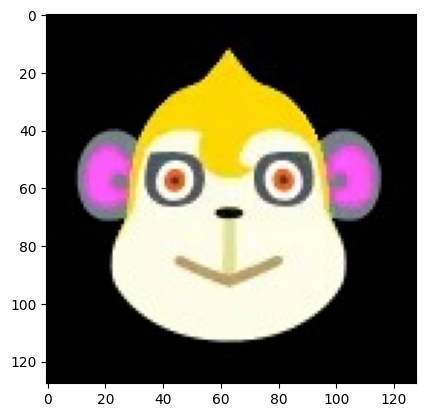

In [22]:
import matplotlib.pyplot as plt

plt.imshow(image[0].cpu().squeeze().permute(1,2,0))

In [25]:
preds = preds.argmax(-1).cpu()

pred_idx = str(np.array(preds)[0])
label_idx = str(np.array(label)[0])

print('예측 레이블:', id2label[pred_idx])
print('실제 레이블:', id2label[label_idx])

예측 레이블: cat
실제 레이블: monkey
